In [1]:
import sys  
sys.path.insert(0, '/home/yuxiao/nii_project/src')

# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow
from contrastive import ContrastiveLoss
import torchvision
from PIL import Image
import os
from tqdm import tqdm
import cv2

# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv

In [2]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [3]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

# eval_dataset = SiameseDataset(
#     val_csv,
#     val_dir,
#     transform=transforms.Compose(
#         [transforms.Resize((105, 105)), transforms.ToTensor()]
#     ),
# )

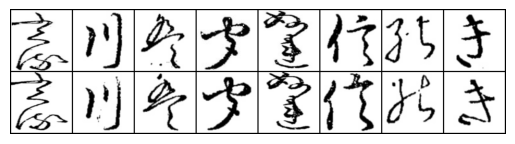

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [4]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # initialize the weights
        # self.resnet.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [7]:
# train the model
def train(
    model, device, criterion, optimizer, train_dataloader, train_losses, t_correct_set
):
    model.train()
    train_loss = 0
    correct = 0

    for _, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        optimizer.zero_grad()
        output1, output2 = model(images_1, images_2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = criterion(output1, output2, targets)
        train_loss += loss
        loss.backward()
        optimizer.step()
        pred = torch.where(
            euclidean_distance > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()

    train_loss /= len(train_dataloader.dataset)
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            train_loss,
            correct,
            len(train_dataloader.dataset),
            100.0 * correct / len(train_dataloader.dataset),
        )
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    t_correct_set.append(correct / len(train_dataloader.dataset))
    return train_loss


def eval(model, device, criterion, eval_dataloader, val_losses, v_correct_set):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images_1, images_2, targets in eval_dataloader:
            images_1, images_2, targets = (
                images_1.to(device),
                images_2.to(device),
                targets.to(device),
            )
            output1, output2 = model(images_1, images_2)
            loss = criterion(output1, output2, targets)
            val_loss += loss
            euclidean_distance = F.pairwise_distance(output1, output2)
            pred = torch.where(
                euclidean_distance > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(eval_dataloader.dataset)
    acc = correct / len(eval_dataloader.dataset)

    print(
        "\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            val_loss,
            correct,
            len(eval_dataloader.dataset),
            100.0 * acc,
        )
    )
    val_losses.append(val_loss.cpu().detach().numpy())
    v_correct_set.append(acc)

    return val_loss, acc

In [10]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
# eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
val_losses = []
train_losses = []
t_correct_set = []
v_correct_set = []
best_acc = 0
best_loss = 9999
# eval(model, device, eval_dataloader)

In [11]:
for epoch in tqdm(range(30)):
    train_loss = train(
        model,
        device,
        criterion,
        optimizer,
        train_dataloader,
        train_losses,
        t_correct_set,
    )
    val_loss, acc = eval(
        model, device, criterion, test_dataloader, val_losses, v_correct_set
    )

    print("-" * 20)

    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Best Validation Loss: {best_loss}")
        torch.save(model.state_dict(), "../siamese/content/model_contrastive_new.pth")
        print("Model Saved Successfully")
        print("-" * 20)

  0%|          | 0/30 [00:00<?, ?it/s]


Train set: Average loss: 0.0183, Accuracy: 15696/22987 (68%)

Val set: Average loss: 0.0138, Accuracy: 184/233 (79%)
--------------------
Best Validation Loss: 0.013753313571214676


  3%|▎         | 1/30 [04:18<2:05:03, 258.76s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0116, Accuracy: 17406/22987 (76%)

Val set: Average loss: 0.0117, Accuracy: 186/233 (80%)
--------------------
Best Validation Loss: 0.011732564307749271


  7%|▋         | 2/30 [08:37<2:00:41, 258.62s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0107, Accuracy: 17775/22987 (77%)


 10%|█         | 3/30 [12:50<1:55:21, 256.35s/it]


Val set: Average loss: 0.0122, Accuracy: 176/233 (76%)
--------------------

Train set: Average loss: 0.0104, Accuracy: 17884/22987 (78%)

Val set: Average loss: 0.0103, Accuracy: 193/233 (83%)
--------------------
Best Validation Loss: 0.0102645019069314


 13%|█▎        | 4/30 [16:52<1:48:34, 250.55s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0101, Accuracy: 17919/22987 (78%)


 17%|█▋        | 5/30 [20:34<1:40:04, 240.19s/it]


Val set: Average loss: 0.0107, Accuracy: 185/233 (79%)
--------------------

Train set: Average loss: 0.0103, Accuracy: 17936/22987 (78%)


 20%|██        | 6/30 [24:09<1:32:36, 231.51s/it]


Val set: Average loss: 0.0107, Accuracy: 194/233 (83%)
--------------------

Train set: Average loss: 0.0101, Accuracy: 18092/22987 (79%)

Val set: Average loss: 0.0099, Accuracy: 183/233 (79%)
--------------------
Best Validation Loss: 0.00989895686507225


 23%|██▎       | 7/30 [27:43<1:26:33, 225.79s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0101, Accuracy: 18057/22987 (79%)


 27%|██▋       | 8/30 [31:22<1:22:02, 223.76s/it]


Val set: Average loss: 0.0109, Accuracy: 198/233 (85%)
--------------------

Train set: Average loss: 0.0097, Accuracy: 18199/22987 (79%)


 30%|███       | 9/30 [35:08<1:18:33, 224.47s/it]


Val set: Average loss: 0.0105, Accuracy: 203/233 (87%)
--------------------

Train set: Average loss: 0.0094, Accuracy: 18330/22987 (80%)


 33%|███▎      | 10/30 [38:53<1:14:55, 224.76s/it]


Val set: Average loss: 0.0106, Accuracy: 200/233 (86%)
--------------------

Train set: Average loss: 0.0090, Accuracy: 18539/22987 (81%)

Val set: Average loss: 0.0097, Accuracy: 193/233 (83%)
--------------------
Best Validation Loss: 0.0097277807071805


 37%|███▋      | 11/30 [42:41<1:11:26, 225.58s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0088, Accuracy: 18624/22987 (81%)

Val set: Average loss: 0.0092, Accuracy: 209/233 (90%)
--------------------
Best Validation Loss: 0.009248554706573486


 40%|████      | 12/30 [46:26<1:07:39, 225.50s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0084, Accuracy: 18769/22987 (82%)

Val set: Average loss: 0.0080, Accuracy: 199/233 (85%)
--------------------
Best Validation Loss: 0.008042823523283005


 43%|████▎     | 13/30 [50:00<1:02:52, 221.90s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0082, Accuracy: 18856/22987 (82%)


 47%|████▋     | 14/30 [53:33<58:28, 219.30s/it]  


Val set: Average loss: 0.0113, Accuracy: 205/233 (88%)
--------------------

Train set: Average loss: 0.0080, Accuracy: 18924/22987 (82%)


 50%|█████     | 15/30 [57:07<54:24, 217.64s/it]


Val set: Average loss: 0.0087, Accuracy: 206/233 (88%)
--------------------

Train set: Average loss: 0.0078, Accuracy: 19066/22987 (83%)


 53%|█████▎    | 16/30 [1:00:41<50:31, 216.52s/it]


Val set: Average loss: 0.0083, Accuracy: 206/233 (88%)
--------------------

Train set: Average loss: 0.0076, Accuracy: 19146/22987 (83%)


 57%|█████▋    | 17/30 [1:04:16<46:49, 216.15s/it]


Val set: Average loss: 0.0085, Accuracy: 209/233 (90%)
--------------------

Train set: Average loss: 0.0075, Accuracy: 19188/22987 (83%)


 60%|██████    | 18/30 [1:07:49<43:01, 215.12s/it]


Val set: Average loss: 0.0090, Accuracy: 203/233 (87%)
--------------------

Train set: Average loss: 0.0073, Accuracy: 19267/22987 (84%)

Val set: Average loss: 0.0078, Accuracy: 209/233 (90%)
--------------------
Best Validation Loss: 0.007762697525322437


 63%|██████▎   | 19/30 [1:11:24<39:26, 215.14s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0071, Accuracy: 19361/22987 (84%)

Val set: Average loss: 0.0075, Accuracy: 204/233 (88%)
--------------------
Best Validation Loss: 0.007491763681173325


 67%|██████▋   | 20/30 [1:15:00<35:52, 215.28s/it]

Model Saved Successfully
--------------------

Train set: Average loss: 0.0070, Accuracy: 19402/22987 (84%)


 70%|███████   | 21/30 [1:18:49<32:56, 219.60s/it]


Val set: Average loss: 0.0080, Accuracy: 200/233 (86%)
--------------------

Train set: Average loss: 0.0069, Accuracy: 19517/22987 (85%)


 73%|███████▎  | 22/30 [1:22:37<29:35, 221.88s/it]


Val set: Average loss: 0.0088, Accuracy: 202/233 (87%)
--------------------

Train set: Average loss: 0.0067, Accuracy: 19551/22987 (85%)


 77%|███████▋  | 23/30 [1:26:33<26:22, 226.12s/it]


Val set: Average loss: 0.0082, Accuracy: 205/233 (88%)
--------------------

Train set: Average loss: 0.0067, Accuracy: 19632/22987 (85%)


 80%|████████  | 24/30 [1:30:21<22:41, 226.95s/it]


Val set: Average loss: 0.0078, Accuracy: 210/233 (90%)
--------------------

Train set: Average loss: 0.0066, Accuracy: 19638/22987 (85%)


 83%|████████▎ | 25/30 [1:34:18<19:08, 229.76s/it]


Val set: Average loss: 0.0083, Accuracy: 203/233 (87%)
--------------------

Train set: Average loss: 0.0066, Accuracy: 19707/22987 (86%)


 87%|████████▋ | 26/30 [1:38:10<15:21, 230.41s/it]


Val set: Average loss: 0.0099, Accuracy: 213/233 (91%)
--------------------

Train set: Average loss: 0.0063, Accuracy: 19781/22987 (86%)


 90%|█████████ | 27/30 [1:42:04<11:34, 231.46s/it]


Val set: Average loss: 0.0078, Accuracy: 206/233 (88%)
--------------------

Train set: Average loss: 0.0064, Accuracy: 19783/22987 (86%)


 93%|█████████▎| 28/30 [1:45:57<07:44, 232.03s/it]


Val set: Average loss: 0.0081, Accuracy: 209/233 (90%)
--------------------

Train set: Average loss: 0.0063, Accuracy: 19860/22987 (86%)


 97%|█████████▋| 29/30 [1:49:49<03:52, 232.07s/it]


Val set: Average loss: 0.0077, Accuracy: 212/233 (91%)
--------------------

Train set: Average loss: 0.0062, Accuracy: 19855/22987 (86%)


100%|██████████| 30/30 [1:53:41<00:00, 227.39s/it]


Val set: Average loss: 0.0089, Accuracy: 203/233 (87%)
--------------------


In [14]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        output1, output2 = model(images_1, images_2)
        loss = criterion(output1, output2, targets)
        test_loss += loss
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred = torch.where(
            euclidean_distance > 1, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss / len(test_dataloader.dataset),
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0071, Accuracy: 224/233 (96%)



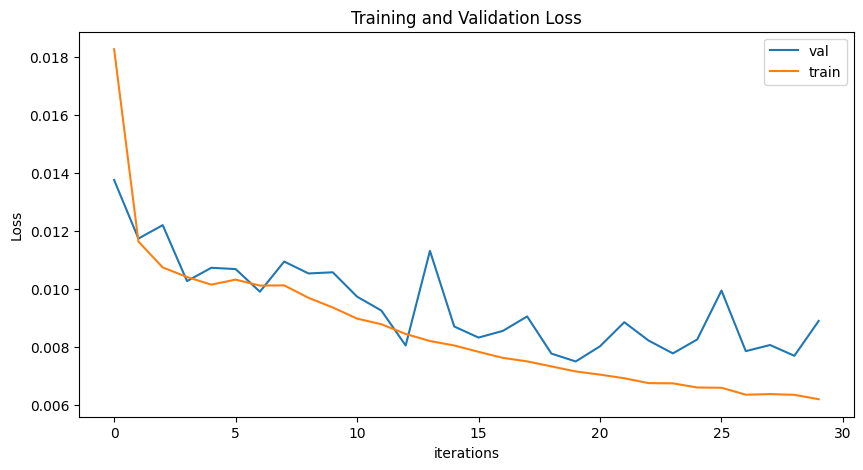

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

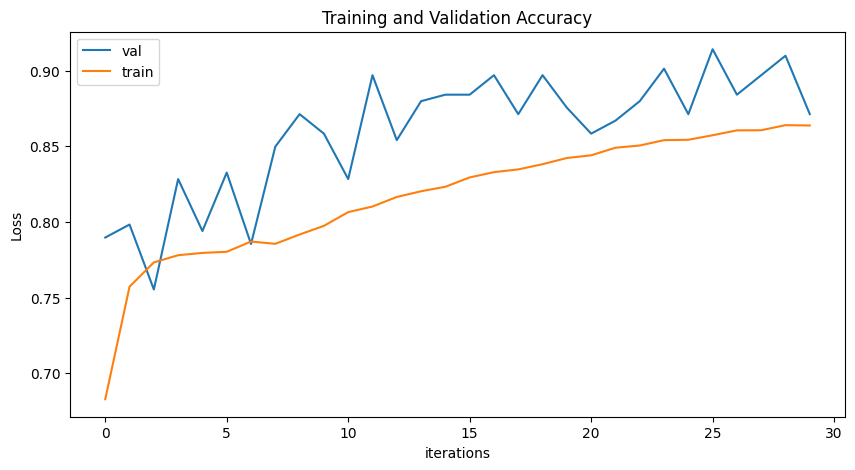

In [16]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(v_correct_set, label="val")
plt.plot(t_correct_set, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

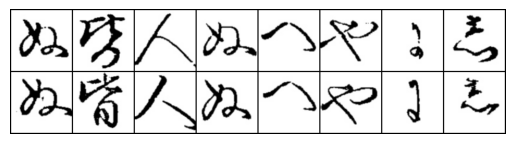

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [17]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [18]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
output1, output2 = model(images_1, images_2)
euclidean_distance = F.pairwise_distance(output1, output2)
pred = torch.where(
    euclidean_distance > 1, 1, 0
)  # get the index of the max log-probability

In [19]:
euclidean_distance

tensor([1.3773, 3.1823, 1.6416, 0.8691, 0.8763, 2.1967, 2.4967, 1.7963],
       device='cuda:0', grad_fn=<NormBackward1>)

In [20]:
pred

tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("../siamese/content/model_contrastive_new.pth"))
model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [21]:
transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])


def transformation(transform, image1_path):
    img = Image.open(image1_path)
    img = img.convert("L")

    # Apply image transformations
    img = transform(img)
    return img


img1 = transformation(transform, "../dataset/2/6135_001_126_0.jpg").to(device)
img2 = transformation(transform, "../dataset/2/18290_001_23_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.7364], device='cuda:0', grad_fn=<NormBackward1>)

In [22]:
computer_sim_score(
    "../dataset/2/13756_001_158_0.jpg", "../dataset/2/29962_001_70_1.jpg"
)

NameError: name 'computer_sim_score' is not defined

In [23]:
img1 = transformation(transform, "../dataset/char_block/与世/2/13756_001_158_0.jpg").to(
    device
)
img2 = transformation(transform, "../dataset/2/29962_001_70_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([2.3187], device='cuda:0', grad_fn=<NormBackward1>)

In [24]:
img1 = transformation(transform, "../dataset/2/13756_001_158_0.jpg").to(device)
img2 = transformation(transform, "../dataset/2/29962_001_70_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.7506], device='cuda:0', grad_fn=<NormBackward1>)

In [25]:
img1 = transformation(transform, "../dataset/2/22089_001_39_0.jpg").to(device)
img2 = transformation(transform, "../dataset/2/30472_001_72_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.7643], device='cuda:0', grad_fn=<NormBackward1>)

In [26]:
img1 = transformation(transform, "../dataset/2/462_001_101_1.jpg").to(device)
img2 = transformation(transform, "../dataset/2/10640_001_145_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.7812], device='cuda:0', grad_fn=<NormBackward1>)

In [27]:
img1 = transformation(transform, "../dataset/2/160_001_100_0.jpg").to(device)
img2 = transformation(transform, "../dataset/2/28161_001_63_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.4040], device='cuda:0', grad_fn=<NormBackward1>)

In [28]:
img1 = transformation(transform, "../dataset/2/1990_001_108_1.jpg").to(device)
img2 = transformation(transform, "../dataset/2/266_001_100_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([1.1182], device='cuda:0', grad_fn=<NormBackward1>)

In [29]:
img1 = transformation(transform, "../dataset/2/19090_001_26_1.jpg").to(device)
img2 = transformation(transform, "../dataset/2/26135_001_55_1.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.6745], device='cuda:0', grad_fn=<NormBackward1>)

In [30]:
img1 = transformation(transform, "../dataset/2/6009_001_125_1.jpg").to(device)
img2 = transformation(transform, "../dataset/2/3215_001_113_0.jpg").to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.7541], device='cuda:0', grad_fn=<NormBackward1>)

In [14]:
from skimage.metrics import structural_similarity
from skimage.registration import phase_cross_correlation

In [15]:
def registration(img1_path, img2_path):
    imgRef = cv2.imread(img1_path)
    imgTest = cv2.imread(img2_path)
    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    # Pad the images to same size
    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    # pixel precision first
    shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
    # print(f"Detected subpixel offset (y, x): {shift}")

    height_offset, weith_offset = int(shift[0]), int(shift[1])

    # Compute Similarity
    if height_offset > 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[height_offset:, weith_offset:]
        imgTest_grey = imgTest_grey[:-height_offset, :-weith_offset]

    elif height_offset > 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[height_offset:, :weith_offset]
        imgTest_grey = imgTest_grey[:-height_offset, -weith_offset:]

    elif height_offset < 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:height_offset, weith_offset:]
        imgTest_grey = imgTest_grey[-height_offset:, :-weith_offset]

    elif height_offset < 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:height_offset, :weith_offset]
        imgTest_grey = imgTest_grey[-height_offset:, -weith_offset:]

    elif height_offset == 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:, weith_offset:]
        imgTest_grey = imgTest_grey[:, :-weith_offset]

    elif height_offset == 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:, :weith_offset]
        imgTest_grey = imgTest_grey[:, -weith_offset:]

    elif height_offset > 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[height_offset:, :]
        imgTest_grey = imgTest_grey[:-height_offset, :]

    elif height_offset < 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[:height_offset, :]
        imgTest_grey = imgTest_grey[-height_offset:, :]

    elif height_offset == 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey
        imgTest_grey = imgTest_grey

    return imgRef_grey, imgTest_grey


def register(img1_path, img2_path):
    imgRef_grey, imgTest_grey = registration(img1_path, img2_path)

    imgRef_grey = transform(Image.fromarray(imgRef_grey).convert("L"))
    imgTest_grey = transform(Image.fromarray(imgTest_grey).convert("L"))

    return imgRef_grey.to(device), imgTest_grey.to(device)


def computer_sim_score(img1_path, img2_path):
    imgRef_grey, imgTest_grey = registration(img1_path, img2_path)

    (score, diff) = structural_similarity(
        imgRef_grey,
        imgTest_grey,
        full=True,
    )

    return score

In [16]:
transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])


def transformation(transform, image1_path):
    img = Image.open(image1_path)
    img = img.convert("L")

    # Apply image transformations
    img = transform(img)
    return img

In [32]:
img1 = transformation(
    transform,
    "/home/yuxiao/nii_project/dataset/2/3548_001_115_0.jpg",
).to(device)
img2 = transformation(
    transform,
    "/home/yuxiao/nii_project/dataset/2/6175_001_126_1.jpg",
).to(device)

o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([0.9633], device='cuda:0', grad_fn=<NormBackward1>)

In [33]:
computer_sim_score(
    "../dataset/2/30979_001_75_0.jpg",
    "../dataset/2/31175_001_75_1.jpg",
)

0.79800515453428